In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import datetime
import yfinance as yf
import networkx as nx

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'BAC', 'V', 'PG', 'KO', 'WMT', 'PEP', 'CVX', 'XOM', 'SLB', 'BA', 'UPS', 'CAT', 'MMM', 'JNJ', 'PFE', 'MRNA', 'DIS', 'NFLX', 'T', 'NVDA', 'ORCL', 'INTC', 'LMT', 'GS', 'COST', 'BTC-USD', 'ETH-USD', 'LTC-USD', 'XRP-USD']

# Get Dataset

In [3]:
def get_dataset(year,portfolio):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    data = yf.download(portfolio, start=start_date, end=end_date)['Adj Close'].dropna()
    
    return data

In [4]:
def calculate_average_clustering(year,tickers=tickers):
    dataset=get_dataset(year,tickers).pct_change().dropna()
    corr=dataset.corr()
    adjacency=corr.values
    
    threshold=np.mean(adjacency)
    
    for i in range(35):
        for j in range(35):
            if adjacency[i,j]<threshold:
                adjacency[i,j]=0
    
    #threshold network
    network=nx.from_numpy_matrix(adjacency)
    
    tickers=corr.columns.tolist()
    mapping = dict(zip(network.nodes, tickers))
    network = nx.relabel_nodes(network, mapping)
    
    clustering_dict = nx.clustering(network)
    
    return clustering_dict

In [5]:
def dataset_parameters(year,stockFileName):
    
    #dataset
    originalRows=35
    data = pd.read_csv(stockFileName,  nrows= originalRows,index_col=['assets'])
    
    #columns
    assetLabels = data.columns.tolist()
    
    #covariance
    dfStockPrices = data
    assetParameters=np.array(dfStockPrices)
    
    return assetLabels,assetParameters

In [6]:
def show_reachability_plot(year, stockFileName):
    
    _,assetParameters=dataset_parameters(2020,stockFileName)
    
    
    # Define the reference point for the reachability plot
    reference_point = 0  # Index of the reference point in the data array
    
    #load dataset
    data = assetParameters
    
    # Compute the distances to the kth nearest neighbors
    k = 5  # Number of nearest neighbors
    neigh = NearestNeighbors(n_neighbors=k+1)  # k+1 to include the reference point
    neigh.fit(data)
    distances, indices = neigh.kneighbors(data)
    
    # Extract the distances to the reference point
    reachability_distances = distances[:, 1:]  # Exclude the reference point itself
    
    # Sort the distances in ascending order
    sorted_distances = np.sort(reachability_distances, axis=0)
    
    # Plot the reachability distances
    plt.plot(range(len(data)), sorted_distances[:, reference_point])
    plt.xlabel('Points sorted by distance')
    plt.ylabel('Reachability Distance')
    plt.title(f'Reachability Plot (Reference Point: {reference_point})')
    plt.show()

In [7]:
def DBSCAN_clustering(year, stockFileName, eps):
    
    assetLabels,assetParameters=dataset_parameters(year,stockFileName)
    
    dbscan=DBSCAN(eps=5);
    dbscan.fit(assetParameters);
    
    nclusters=len(set(dbscan.labels_))-(1 if -1 in dbscan.labels_ else 0);
    
    labels=np.array([i for i in dbscan.labels_ if i!=-1]);
    
    assets = np.array(assetLabels)
    cluster_list=[]
    
    print(nclusters)
    
    for i in range(nclusters):
        clt  = np.where(labels == i)
        assetsCluster = assets[clt]
        cluster_list.append(assetsCluster);
    return cluster_list

# Portfolio with highest mean returns assets

In [8]:
def retReturns(i):
    return meanreturns.get(i)


def portfolio_highest_mean(clusters):
    sorted_list=[]
    for assetList in clusters:
        sorted_list.append(sorted(assetList, key=retReturns,reverse=True))
    
    assets=[]
    for i in sorted_list:
        if len(i)<5:
            assets.extend([j for j in i])
        else:
            assets.extend([j for j in i[0:5]])
                
    return sorted(assets, key=retReturns,reverse=True)[0:7]


# Portfolio with lowest risk assets

In [9]:
def retRisk(i):
    return risk.get(i)


def portfolio_lowest_risk(clusters):
    sorted_list=[]
    for assetList in clusters:
        sorted_list.append(sorted(assetList, key=retRisk,reverse=False))
    
    assets=[]
    for i in sorted_list:
        if len(i)<5:
            assets.extend([j for j in i])
        else:
            assets.extend([j for j in i[0:5]])
    return sorted(assets, key=retReturns,reverse=True)[0:7]


# Portfolio with lowest average clustering coefficient

In [10]:
def retClustering(i):
    return clustering.get(i)


def portfolio_lowest_avg_clustering(clusters):
    sorted_list=[]
    for assetList in clusters:
        sorted_list.append(sorted(assetList, key=retClustering,reverse=False))
    
    assets=[]
    for i in sorted_list:
        if len(i)<5:
            assets.extend([j for j in i])
        else:
            assets.extend([j for j in i[0:5]])
    return sorted(assets, key=retReturns,reverse=True)[0:7]


# Diversification Index- Using Equal Weighted(EW) Portfolio

In [11]:
def diversification_ratio(year,portfolio):
    
    #Download Adjacent closing prices for the selected assets in the portfolio
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    data = yf.download(portfolio, start=start_date, end=end_date)['Adj Close']
    
    #calculating returns
    returns = data.pct_change().dropna()
    
    #calculating volatility (standard deviation)
    volatilities = returns.std() * np.sqrt(251)
    
    #calculating covariance of the returns
    cov_matrix = returns.cov() * 252
    
    #Constructing E.W portfolio
    weights = np.ones(len(data.columns)) / len(data.columns)
    
    #Calculating the weighted sum of individual volatilities
    weighted_vol_sum = np.dot(volatilities, weights)
    
    # Computing the portfolio volatility using the covariance matrix
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))
    
    # Calculating the Diversification Ratio
    diversification_ratio = weighted_vol_sum / portfolio_volatility
    
    return diversification_ratio

In [12]:
def diversification_dictionary(year,p1,p2,p3):
    d_d={}
    d_d['highest_return']=diversification_ratio(year,p1)
    d_d['lowest_risk']=diversification_ratio(year,p2)
    d_d['lowest_clustering']=diversification_ratio(year,p3)
    
    return d_d

# Code Execution

## Put relevant variables

In [54]:
year=2023
correlation_matrix = f'./mi_cor_mat_{year}.csv'
meanreturns= dict((get_dataset(year,tickers).pct_change().dropna()).mean())
risk=dict((get_dataset(year,tickers).pct_change().dropna()).std())
clustering=calculate_average_clustering(year)

correlation_method='mi'

[*********************100%%**********************]  35 of 35 completed
[*********************100%%**********************]  35 of 35 completed
[*********************100%%**********************]  35 of 35 completed


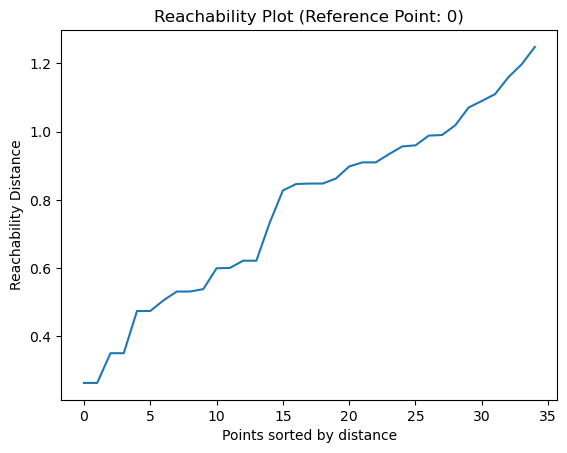

In [55]:
show_reachability_plot(year,correlation_matrix)

In [61]:
eps=1

## Get the portfolios

In [62]:
portfolio_with_highest_mean=portfolio_highest_mean(DBSCAN_clustering(year,correlation_matrix,eps))
portfolio_with_lowest_risk=portfolio_lowest_risk(DBSCAN_clustering(year,correlation_matrix,eps))
portfolio_with_lowest_avg_clustering_coef=portfolio_lowest_avg_clustering(DBSCAN_clustering(year,correlation_matrix,eps))

1
1
1


In [63]:
print(portfolio_with_highest_mean)
print(portfolio_with_lowest_risk)
print(portfolio_with_lowest_avg_clustering_coef)

['NVDA', 'BTC-USD', 'TSLA', 'XRP-USD', 'ETH-USD']
['V', 'WMT', 'PG', 'PEP', 'KO']
['ETH-USD', 'V', 'T', 'MMM', 'JNJ']


In [64]:
print((yf.download(portfolio_with_highest_mean, start=f'{year}-01-01', end=f'{year}-12-31')['Adj Close'].pct_change()*100).dropna().mean().sum())
print((yf.download(portfolio_with_lowest_risk, start=f'{year}-01-01', end=f'{year}-12-31')['Adj Close'].pct_change()*100).dropna().mean().sum())
print((yf.download(portfolio_with_lowest_avg_clustering_coef, start=f'{year}-01-01', end=f'{year}-12-31')['Adj Close'].pct_change()*100).dropna().mean().sum())

[*********************100%%**********************]  5 of 5 completed
1.393290462458904
[*********************100%%**********************]  5 of 5 completed
0.13214979644706748
[*********************100%%**********************]  5 of 5 completed
0.2431588107571888


## Check Diversification Ratio

In [65]:
diversification_dictionary(year,portfolio_with_highest_mean,portfolio_with_lowest_risk,portfolio_with_lowest_avg_clustering_coef)

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


{'highest_return': 1.5029680321589336,
 'lowest_risk': 1.3663619749093285,
 'lowest_clustering': 1.6880901273239122}

## Download Dataset 

### Dataset constructed of stocks with highest mean

In [66]:
get_dataset(year,portfolio_with_highest_mean).to_csv(f'{correlation_method}_DBSCAN_{year}_highest_mean.csv')

[*********************100%%**********************]  5 of 5 completed


### Dataset constructed of stocks with lowest risk

In [67]:
get_dataset(year,portfolio_with_lowest_risk).to_csv(f'{correlation_method}_DBSCAN_{year}_lowest_risk.csv')

[*********************100%%**********************]  5 of 5 completed


### Dataset constructed of stocks with lowest average clustering coef

In [68]:
get_dataset(year,portfolio_with_lowest_avg_clustering_coef).to_csv(f'{correlation_method}_DBSCAN_{year}_lowest_average_clustering.csv')

[*********************100%%**********************]  5 of 5 completed
